In [ ]:
!pip install seaborn --quiet

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import gc
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device is:',device)

Device is: cpu


In [3]:
#train_csv_path = "/kaggle/input/rsna-breast-cancer-detection/train.csv"
#train_image_dir = "/kaggle/input/rsna-mammogram-pngs-enhanced/png_train_images"

In [5]:
#train = pd.read_csv(train_csv_path)
#train

In [12]:
import os

folder_path = 'png_train_images/'  
files = os.listdir(folder_path)

In [20]:
from pathlib import Path

train = pd.read_csv("train.csv")

train_image_dir  = Path('png_train_images/')

path = []
for i in tqdm(range(len(df))):
    row = train.iloc[i, :]
    filename = str(row.patient_id) + "/" + str(row.image_id) + ".png"
    path.append(image_path /  filename )
train["path"] = path

100%|██████████████████████████████████| 54706/54706 [00:02<00:00, 26699.43it/s]


In [21]:
images_ = train[['patient_id', 'image_id', 'cancer','difficult_negative_case']]
images_['file_path'] = images_.apply(lambda x: os.path.join(train_image_dir, str(x.patient_id), str(x.image_id) + '.png'), axis=1)
images_.head(1)

,patient_id,image_id,cancer,difficult_negative_case,file_path
0,10006,462822612,0,False,png_train_images/10006/462822612.png


#### The number and proportion of the positive and negative cases

In [ ]:
pro = images_.groupby('cancer')["difficult_negative_case"].value_counts().reset_index(drop=True)
pro['proportion'] = pro['count']/len(images_)
display(pro)

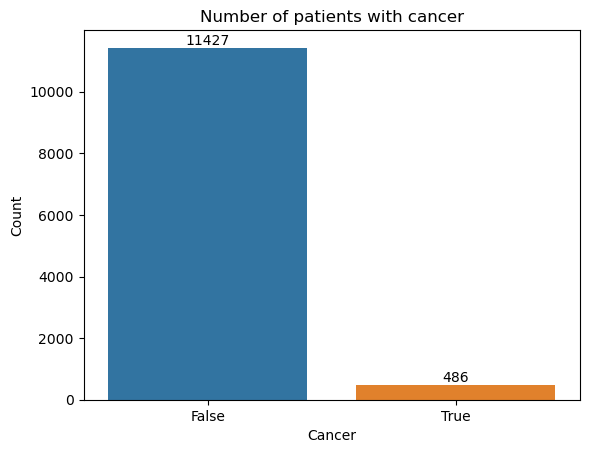

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

def has_cancer(c):
    return c > 0

cancer_per_patient = train.groupby("patient_id")["cancer"].sum().apply(has_cancer)

ax = sns.countplot(x=cancer_per_patient)
ax.bar_label(ax.containers[0])

plt.xlabel("Cancer")
plt.ylabel("Count")
plt.title("Number of patients with cancer")

plt.show()

#### The age distribution

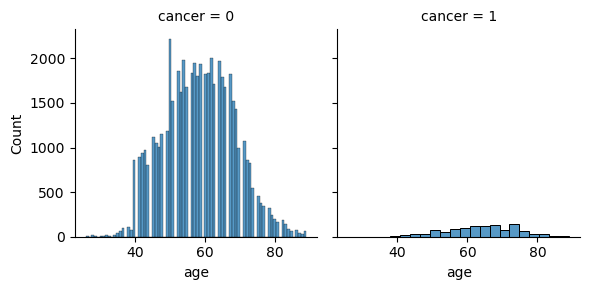

In [39]:
g = sns.FacetGrid(train, col = 'cancer')
g.map(sns.histplot, 'age' )

### Alternative: detailed and bigger view
# sns.displot(train[train['cancer']==1].age, bins=50, kde=True)
# sns.displot(train[train['cancer']==0].age, bins=50, kde=True)
# plt.show()

#### As Cancer and not cancer are unbalanced interms of samples , we would have to sample data from both class so that model gets the general undrstanding of what both type of data looks like

In [59]:
# Keep only certain negatives
not_cancer = images_[(images_['cancer'] == 0) & (images_['difficult_negative_case'] == False)]
# And all cancers
with_cancer = images_[images_['cancer'] == 1]

# Dividing into train and validation sets
with_cancer_train, with_cancer_val = train_test_split(with_cancer, test_size=158, train_size=1000)
not_cancer_train, not_cancer_val = train_test_split(not_cancer, test_size=158)

# Training and validation data generator

In [60]:
class BreastCancerDataset(Dataset):
    def __init__(self, positive_data, negative_data, image_size):
        self.p_data = positive_data 
        self.n_data = negative_data 
        self.data_cnt = max(len(positive_data),len(negative_data))
        # resoluton of the image required by the model
        self.image_size = image_size
            
    def __len__(self):
        return self.data_cnt
                
    def normalize_image(self, image):
        min_val = np.min(image)
        max_val = np.max(image)
        image = (image - min_val) / (max_val - min_val)
        return image
                
    def __getitem__(self, index):
        # Alternate the postive and negative samples
        file_path = ''
        label = 0
        if (index % 2) == 0:
            file_path = self.p_data.file_path.iloc[index % 1000] # we have max 1000 positive samples
            label = 1
        else:
            file_path = self.n_data.file_path.iloc[index]
        
        try:
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (self.image_size[1], self.image_size[0]))
            image = np.expand_dims(image, axis=-1)
            image = np.transpose(image, (2, 0, 1))
            image = self.normalize_image(image)
            return image, np.eye(2)[label]
        except Exception as e:
            print(f'Error loading image from {file_path}: {str(e)}')
            return None, None

In [61]:
# Define batch size and target size
batch_size = 100
image_size = (256, 256)

# Create data generators using tf.data
train_dataset = BreastCancerDataset(with_cancer_train, not_cancer_train, image_size)
val_dataset = BreastCancerDataset(with_cancer_val, not_cancer_val, image_size)

In [62]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

next(iter(val_loader))[1].shape

torch.Size([100, 2])

In [66]:
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(64)

        self.fc_input_size = self.calculate_fc_input_size()

        self.fc1 = nn.Linear(self.fc_input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 2)  
        self.fc4 = nn.Softmax()

    def calculate_fc_input_size(self):
        x = torch.randn(32, 1, 256, 256)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        size = x.view(x.size(0), -1).size(1)
        print("Calculated FC Input Size:", size)
        return size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.fc4(x)
        return x


In [67]:
if torch.cuda.is_available():
      net = MyConvNet().cuda()
else:
      net = MyConvNet()

Calculated FC Input Size: 238144


In [68]:
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
train_losses = []
test_losses = []
running_loss = 0

for epoch in (range(2)):
    train_loss = []
    test_loss = []
                
    for i, (image, label) in enumerate(train_loader):
        X = image.to(device=device, dtype=torch.float32)
        y = label.to(device=device, dtype=torch.float32)  

        y_pred = net(X)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)

        optimizer.step()
        train_loss.append(loss.item())


    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            X_test_batch, y_test_batch = batch
            X_test_batch = X_test_batch.to(device=device, dtype=torch.float32)
            y_test_batch = y_test_batch.to(device=device, dtype=torch.float32)
            y_test_pred = net(X_test_batch)
            test_l = loss_fn(y_test_pred, y_test_batch)
            test_loss.append(test_l.item())

    train_losses.append(np.mean(train_loss))
    test_losses.append(np.mean(test_loss))
    print('epoch ',epoch, ' train_loss ',np.mean(np.mean(train_loss)), ' test_loss ',np.mean(test_loss))

epoch  0  train_loss  0.5542668672828758  test_loss  0.747729480266571
epoch  1  train_loss  0.36270031332969666  test_loss  0.8001757562160492
